In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
import pygeos
import rtree
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
import time
import sys, os
import pickle

In [2]:
# Creation of file with stations in Chamberi with geodf clip

stations_raw = pd.read_csv('C:/Users/Mikel/Desktop/Archivos/Estudios/Ciencia de Datos/TFM/other_data/datos_madrid/estaciones/pmed_ubicacion_09-2022.csv', sep = ';')
stations = list(stations_raw.id.unique())
perimeter_route = 'C:/Users/Mikel/Desktop/Archivos/Estudios/Ciencia de Datos/TFM/Segunda iteración/chamberi.shp'
chamberi_perimeter = gpd.read_file(perimeter_route, encoding='utf-8')
stations_madrid = gpd.GeoDataFrame(
    stations_raw, geometry=gpd.points_from_xy(stations_raw.longitud, stations_raw.latitud))
chamberi_perimeter.crs = "EPSG:4326"
stations_madrid.crs = "EPSG:4326"

# We get the stations that are in the desired area
stations_chamberi = gpd.clip(stations_madrid, chamberi_perimeter)

In [3]:
# We output the stations file for further use

df_estaciones = pd.DataFrame(stations_chamberi)
df_estaciones.to_csv('C:/Users/Mikel/Desktop/estaciones_chamberi.csv', sep=',', encoding='utf-8')

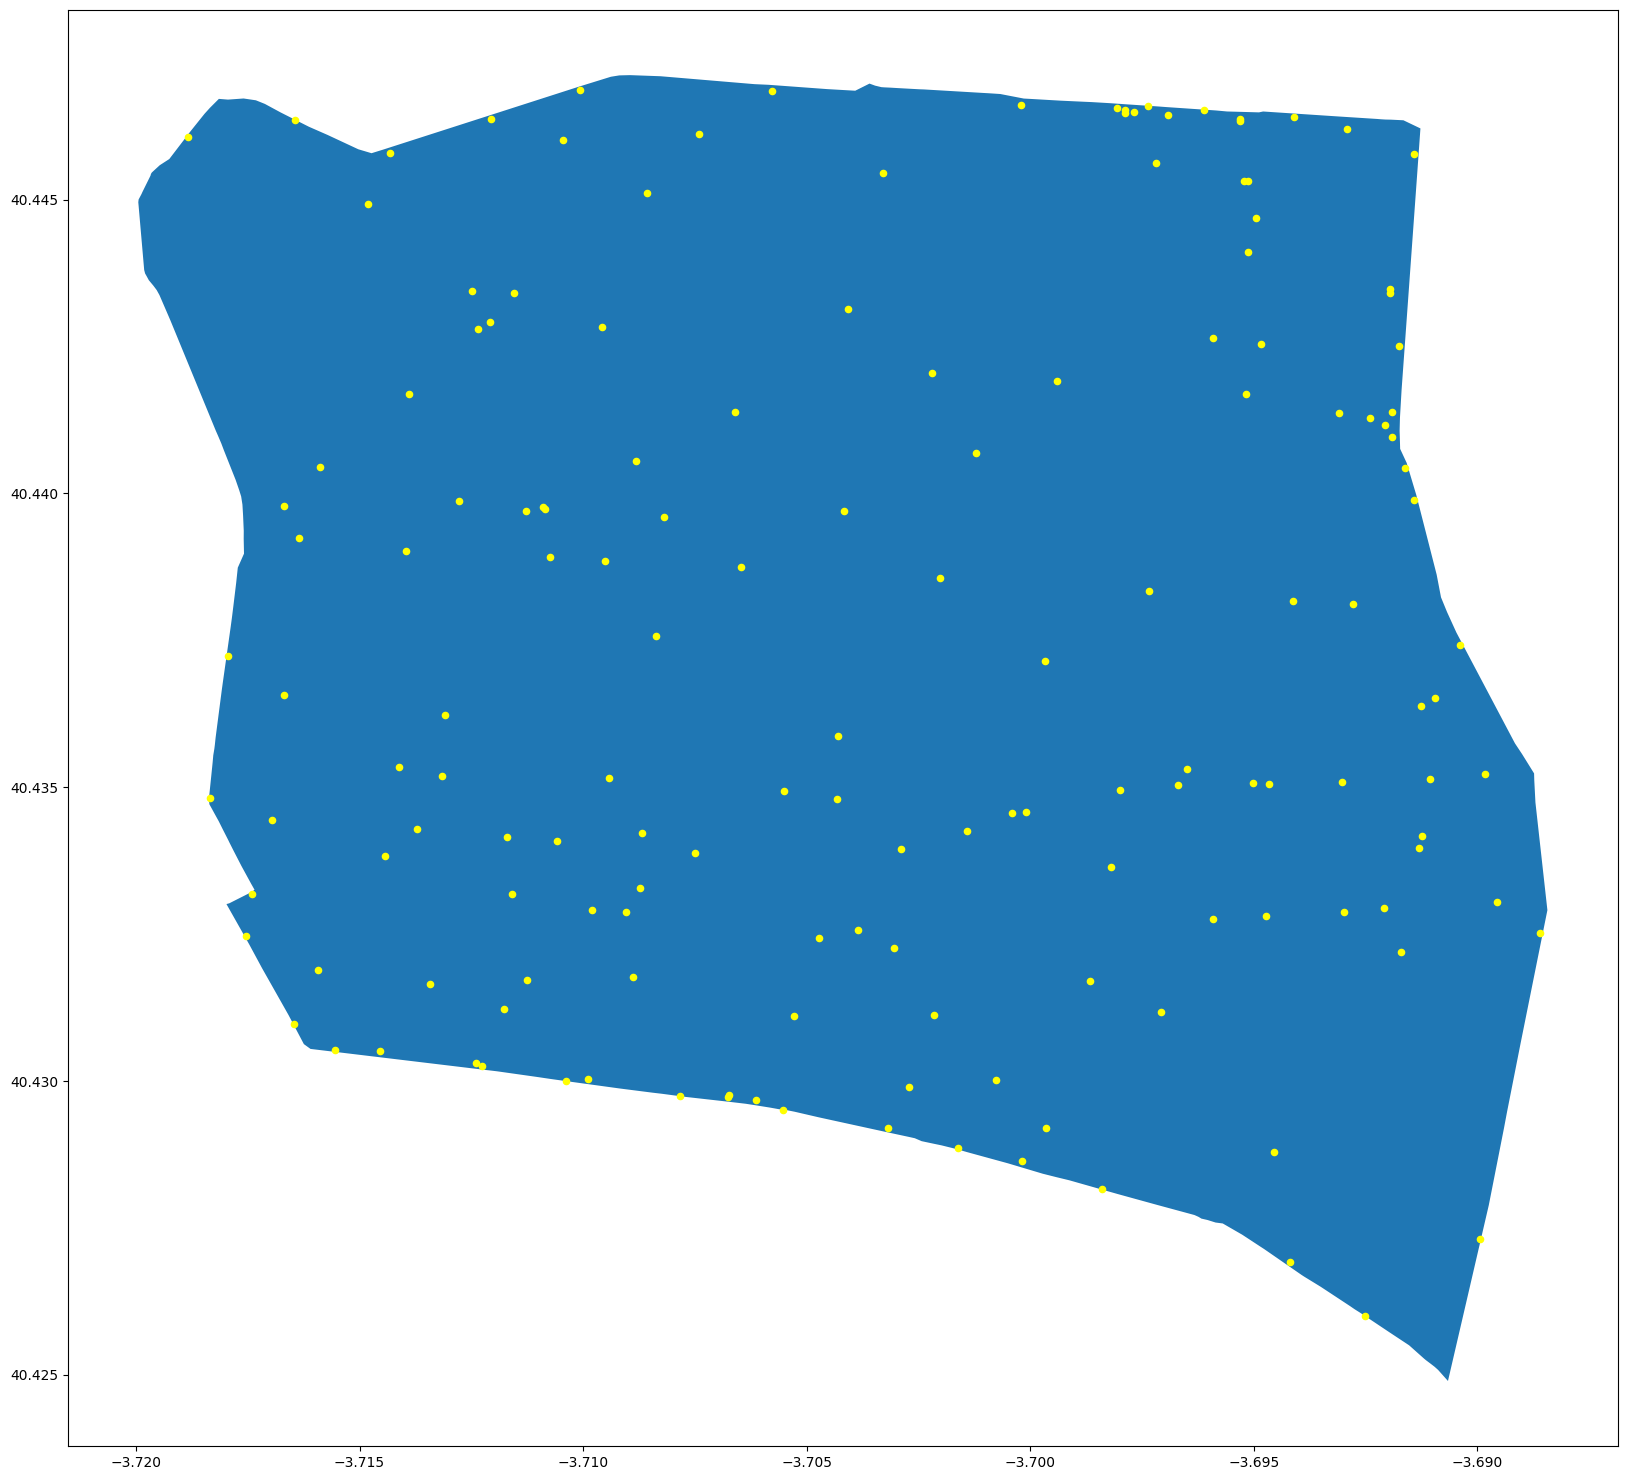

In [4]:
# Plot of the resulting stations

base = chamberi_perimeter.plot(figsize=(20, 20))
stations_chamberi.plot(ax=base, marker='o', color='yellow', markersize=20, figsize=(10,10));

In [5]:
# Preprocessing of Chamberí data from raw csv files and split of resulting dataframe in individual stations df - OK 

def data_basic_preprocesser(stations, year_from, month_from, year_to, month_to):
    '''Processes data from the base dataframes and saves them to the final one'''
    # Creation of the structures that will read the files and read them to a dictionary
    base = 'C:/Users/Mikel/Desktop/Archivos/Estudios/Ciencia de Datos/TFM/other_data/datos_madrid/'
    return_dict = {}
    yearspan = year_to - year_from
    monthspan = month_to - month_from
    span = yearspan * 12 + monthspan + 1
    month = month_from
    year = year_from
    # Iterative process to create the correct file names
    for i in range(span):
        if month < 10:
            filestring =  base + '0' + str(month) + '-' + str(year) +'.csv'
        else:
            filestring = base + str(month) + '-' + str(year) +'.csv'
        df = pd.read_csv(filestring, sep = ';')
        key = str(year) + '-' + str(month)
        df_station = df[df.id.isin(stations)]
        return_dict[key] = df_station
        if month == month_to and year == year_to:
            break
        if month != 12:
            month += 1
        else:
            month = 1
            year += 1
    # Creation of the output dataframe
    df_answer = pd.concat(return_dict.values())
    df_answer['fecha'] = pd.to_datetime(df_answer['fecha'])
    df_answer = df_answer.set_index('fecha')
    return df_answer

def separate_stations(stations_list, df):
    '''Separates a dataframe containing data from every station into a dict where the keys are the stations'''
    ansdic = {}
    for item in stations_list:
        subset_df = df[df.id == item]
        if len(subset_df.index) == 0:
            pass
        else:
            ansdic[item] = subset_df
    return ansdic


def reindex_dict(data_dict):
    '''Interpolates every gap in a time series in order to give a full result'''
    return_df = {}
    for key, value in data_dict.items():
        nas_int = value['intensidad'].isna().sum()
        nas_occ = value['ocupacion'].isna().sum()
        if len(value.index) > 34500:
            df = value.asfreq(freq='15min')
            df['intensidad'].interpolate(method='linear', inplace=True)
            df['ocupacion'].interpolate(method='linear', inplace=True)
            return_df[key] = df
    return return_df

In [6]:
# Application of the above functions

stations_chamberi_list = list(stations_chamberi.id.unique())
traffic = data_basic_preprocesser(stations_chamberi_list, 2021, 7, 2022, 6)
traffic_sep = separate_stations(stations_chamberi_list, traffic)
traffic_sep_2 = reindex_dict(traffic_sep)

In [7]:
# Basic preprocessing prediction function 

# Class to disable/enable printing

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        

def create_dataset(df, previous=1):
    '''Function to shift the target variable, re-arranging it to go 1 value before its actual value'''
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous)]
        dataX.append(a)
        dataY.append(df[i + previous])
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    return dataX, dataY

def train_test(X,y):
    '''Function to separate the datasets in train-test sets'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)
    return X_train, X_test, y_train, y_test

# Basic parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -100
}

def predict(X_train, X_test, y_train, y_test):
    '''Function to make a basic prediction to see if the station's data is acceptable'''
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)
    # train
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)],
                verbose_eval=False)
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    # eval
    r2 = r2_score(y_test, y_pred)
    return r2

def apply_preprocessing(traffic_dict):
    '''Applies the preceding functions'''
    return_dict = {}
    for key in traffic_dict.keys():
        dataset = traffic_dict[key]
        X, y = create_dataset(dataset['intensidad'])
        X_train, X_test, y_train, y_test = train_test(X,y)
        return_dict[key] = (predict(X_train, X_test, y_train, y_test))
    return return_dict

In [8]:
# Executing the above functions 

with HiddenPrints():
    results = apply_preprocessing(traffic_sep_2)

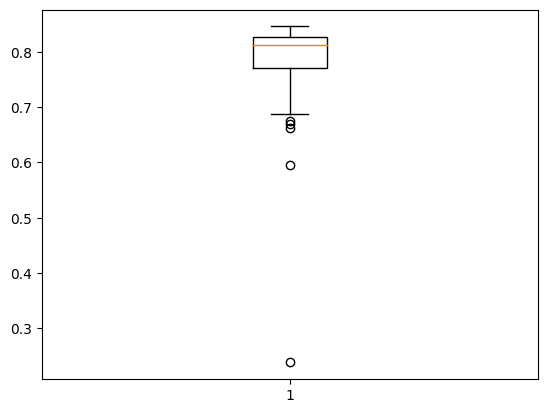

In [9]:
# Boxplot of the R2adj scores

bp = plt.boxplot(results.values())
plt.show()

In [10]:
# We eliminate values with r2-adj lower than boxplot min - OK

[item.get_ydata() for item in bp['caps']]

[array([0.68833831, 0.68833831]), array([0.84589616, 0.84589616])]

In [11]:
# We get rid of the values below 0.69

results_ok = {k:results[k] for k in results if results[k] > 0.69}
updated_list = list(results_ok.keys())

In [12]:
# We generate a new traffic dict without the invalid stations - OK

traffic_sep_3 = {}

for key, df in traffic_sep_2.items():
    if key in updated_list:
        traffic_sep_3[key] = df

In [13]:
def quality_control_1(dataset_dict):
    '''Applies preprocessing criteria to the dataset'''
    # List of unique detector ids, and nested loops to study daily behaviour
    # First criterion: 80% of zeros or others
    # Second criterion: no variation of values during a day
    flawed_80 = []
    flawed_incomplete = []
    for key, df_id in dataset_dict.items():
        ints = np.array(df_id['intensidad'])
        occs = np.array(df_id['ocupacion'])
        unique1, counts1 = np.unique(ints, return_counts=True)
        unique2, counts2 = np.unique(occs, return_counts=True)
    # If there are more than 80% of zeros or any other value in a detector, 
    # we'll discard that detector (occupancy or intensity)
        threshold = 365*0.8*96
        mask1 = counts1 > threshold
        mask2 = counts2 > threshold
        if True in mask1 or True in mask2:
            if detid not in flawed.keys():
                flawed_80.append(key)
            if detid in flawed.keys():
                flawed_80.append(key)
    # We also check for the completeness of each time series, setting the bar 
    # at 80% of the values
        if len(df_id.index) < 0.8*365*96:
            flawed_incomplete.append(key)
    for item in flawed_80:
        if item not in flawed_incomplete:
            flawed_incomplete.append(item)
    return flawed_incomplete

def quality_control_2(detlist, data_dict):
    '''We check for incoherent flows and occupancies'''
    return_dict = {}
    for key, df_id in data_dict.items():
        ints = np.array(df_id['intensidad'])
        occs = np.array(df_id['ocupacion'])
        mask1 = ints != 0
        mask2 = occs != 0
        log = np.logical_xor(mask1, mask2)
        indexes = np.where(log==True)
        return_dict[key] = indexes
    return return_dict
            
def quality_control_3(detlist, data_dict):
    '''We remove time slots with less than 85% of loops reporting results'''
    df = pd.DataFrame()
    for key, df_id in data_dict.items():
        df_id = df_id.reset_index()
        df = pd.concat([df, df_id])  
    bad_tstamps = []
    slots = df['fecha']
    slots_counts = slots.value_counts()
    slots_dict = slots_counts.to_dict()
    threshold = 0.85*len(detlist)
    for key, value in slots_dict.items():
        if value < threshold:
            bad_tstamps.append(key)
    return bad_tstamps

def quality_control_application(detlist, dataset_dict):
    '''We apply the preceding functions'''
    flawed_1 = quality_control_1(dataset_dict)
    detlist_1 = list(set(detlist) - set(flawed_1))
    dataset_1_dict = {}
    for key in detlist_1:
        dataset_1_dict[key] = dataset_dict[key]
    true_dict = quality_control_2(detlist_1, dataset_1_dict)
    dataset_2_dict = {}
    for key, df in dataset_1_dict.items():
        df['num_index'] = list(range(len(df.index)))
        df['intensidad'] = np.where(df.num_index.isin(true_dict[key]), 0, df.intensidad)
        df['ocupacion'] = np.where(df.num_index.isin(true_dict[key]), 0, df.ocupacion)
        dataset_2_dict[key] = df
    dataset_3_dict = {}
    false_tstamps = quality_control_3(detlist_1, dataset_2_dict)
    for key, df in dataset_2_dict.items():
        df['intensidad'] = np.where(df.num_index.isin(false_tstamps), 0, df.intensidad)
        df['ocupacion'] = np.where(df.num_index.isin(false_tstamps), 0, df.ocupacion)
        df = df.asfreq(freq='15min')
        dataset_3_dict[key] = df  
    return dataset_3_dict

In [14]:
# Executing all of the above

traffic_sep_qq = quality_control_application(updated_list, traffic_sep_3)

In [15]:
# We'll handle outliers and negative values

outlier_clean_dict = {}
for key, df in traffic_sep_qq.items():
    int_mean = df['intensidad'].mean()*5
    occ_mean = df['ocupacion'].mean()*5
    cond_1 = (df['intensidad'] < 0)
    cond_2 = (df['ocupacion'] < 0)
    cond_3 = (df['intensidad'] > int_mean)
    cond_4 = (df['ocupacion'] > occ_mean)
    df['intensidad'] = np.where(cond_1, 0, df.intensidad)
    df['ocupacion'] = np.where(cond_2, 0, df.ocupacion)
    df['intensidad'] = np.where(cond_3, np.nan, df.intensidad)
    df['ocupacion'] = np.where(cond_4, np.nan, df.ocupacion)
    df['intensidad'].interpolate(method='linear', inplace=True)
    df['ocupacion'].interpolate(method='linear', inplace=True)
    outlier_clean_dict[key] = df

# Finally, we'll get rid of stations with more than 3 days of zeros or with incomplete time series

final_clean_list = []
def_list = []
clean_dict = {}
for key, df in outlier_clean_dict.items():
    ints = list(df['intensidad'])
    ocs = list(df['ocupacion'])
    zeros_list = [0.0] * 96
    l_i = ''.join(str(i) for i in ints)
    l_j = ''.join(str(i) for i in ocs)
    l_0 = ''.join(str(i) for i in zeros_list)
    if l_0 in l_i or l_0 in l_j:
        def_list.append(key)
for item in updated_list:
    if item not in def_list:
        final_clean_list.append(item)
for key, df in outlier_clean_dict.items():
    if key not in def_list and len(df.index) == 35040:
        final_df = df[['intensidad', 'ocupacion']]
        clean_dict[key] = final_df

In [16]:
# Random sampling

sampled = random.sample(clean_dict.keys(), 10)

sampled_dict = {}

for key, df in clean_dict.items():
    if key in sampled:
        sampled_dict[key] = df   

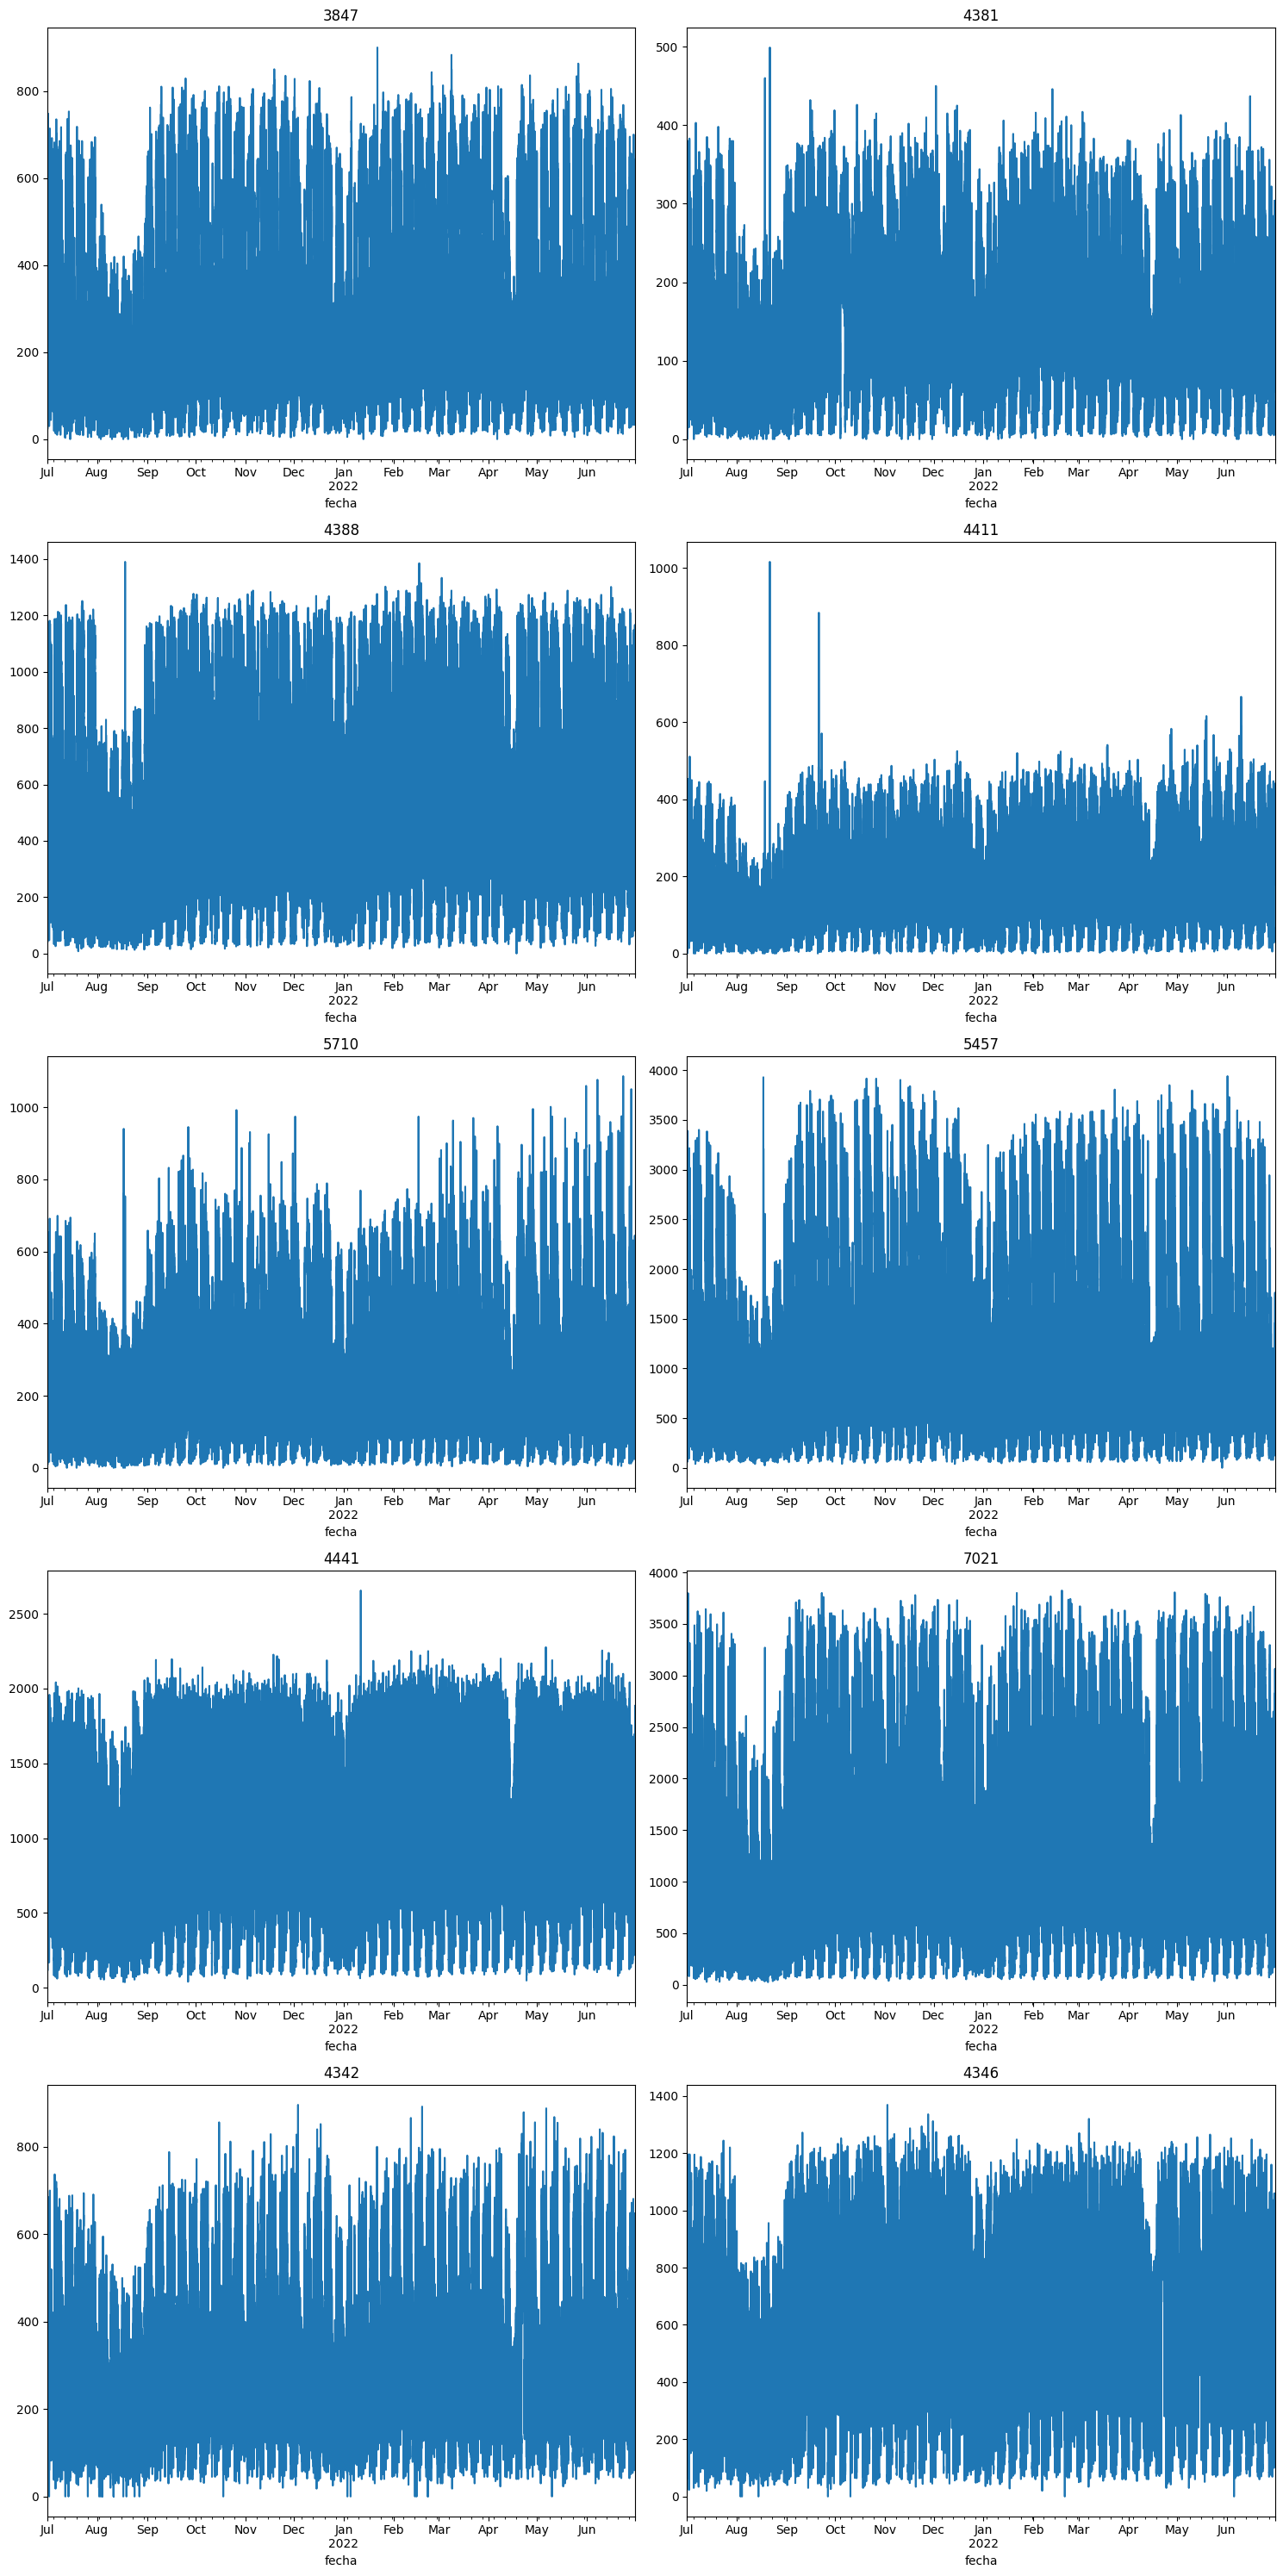

In [17]:
# Plot - intensity

i = 0
j = 0
k = 0

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,30))
for key, df in sampled_dict.items():
    df['intensidad'].plot(ax=axes[i,j])
    axes[i,j].title.set_text(key)
    if j == 1 and i != 4:
        j = 0
        i += 1
    elif j == 1 and i == 4:
        break
    else:
        j += 1
    k += 1

fig.tight_layout()
plt.show()

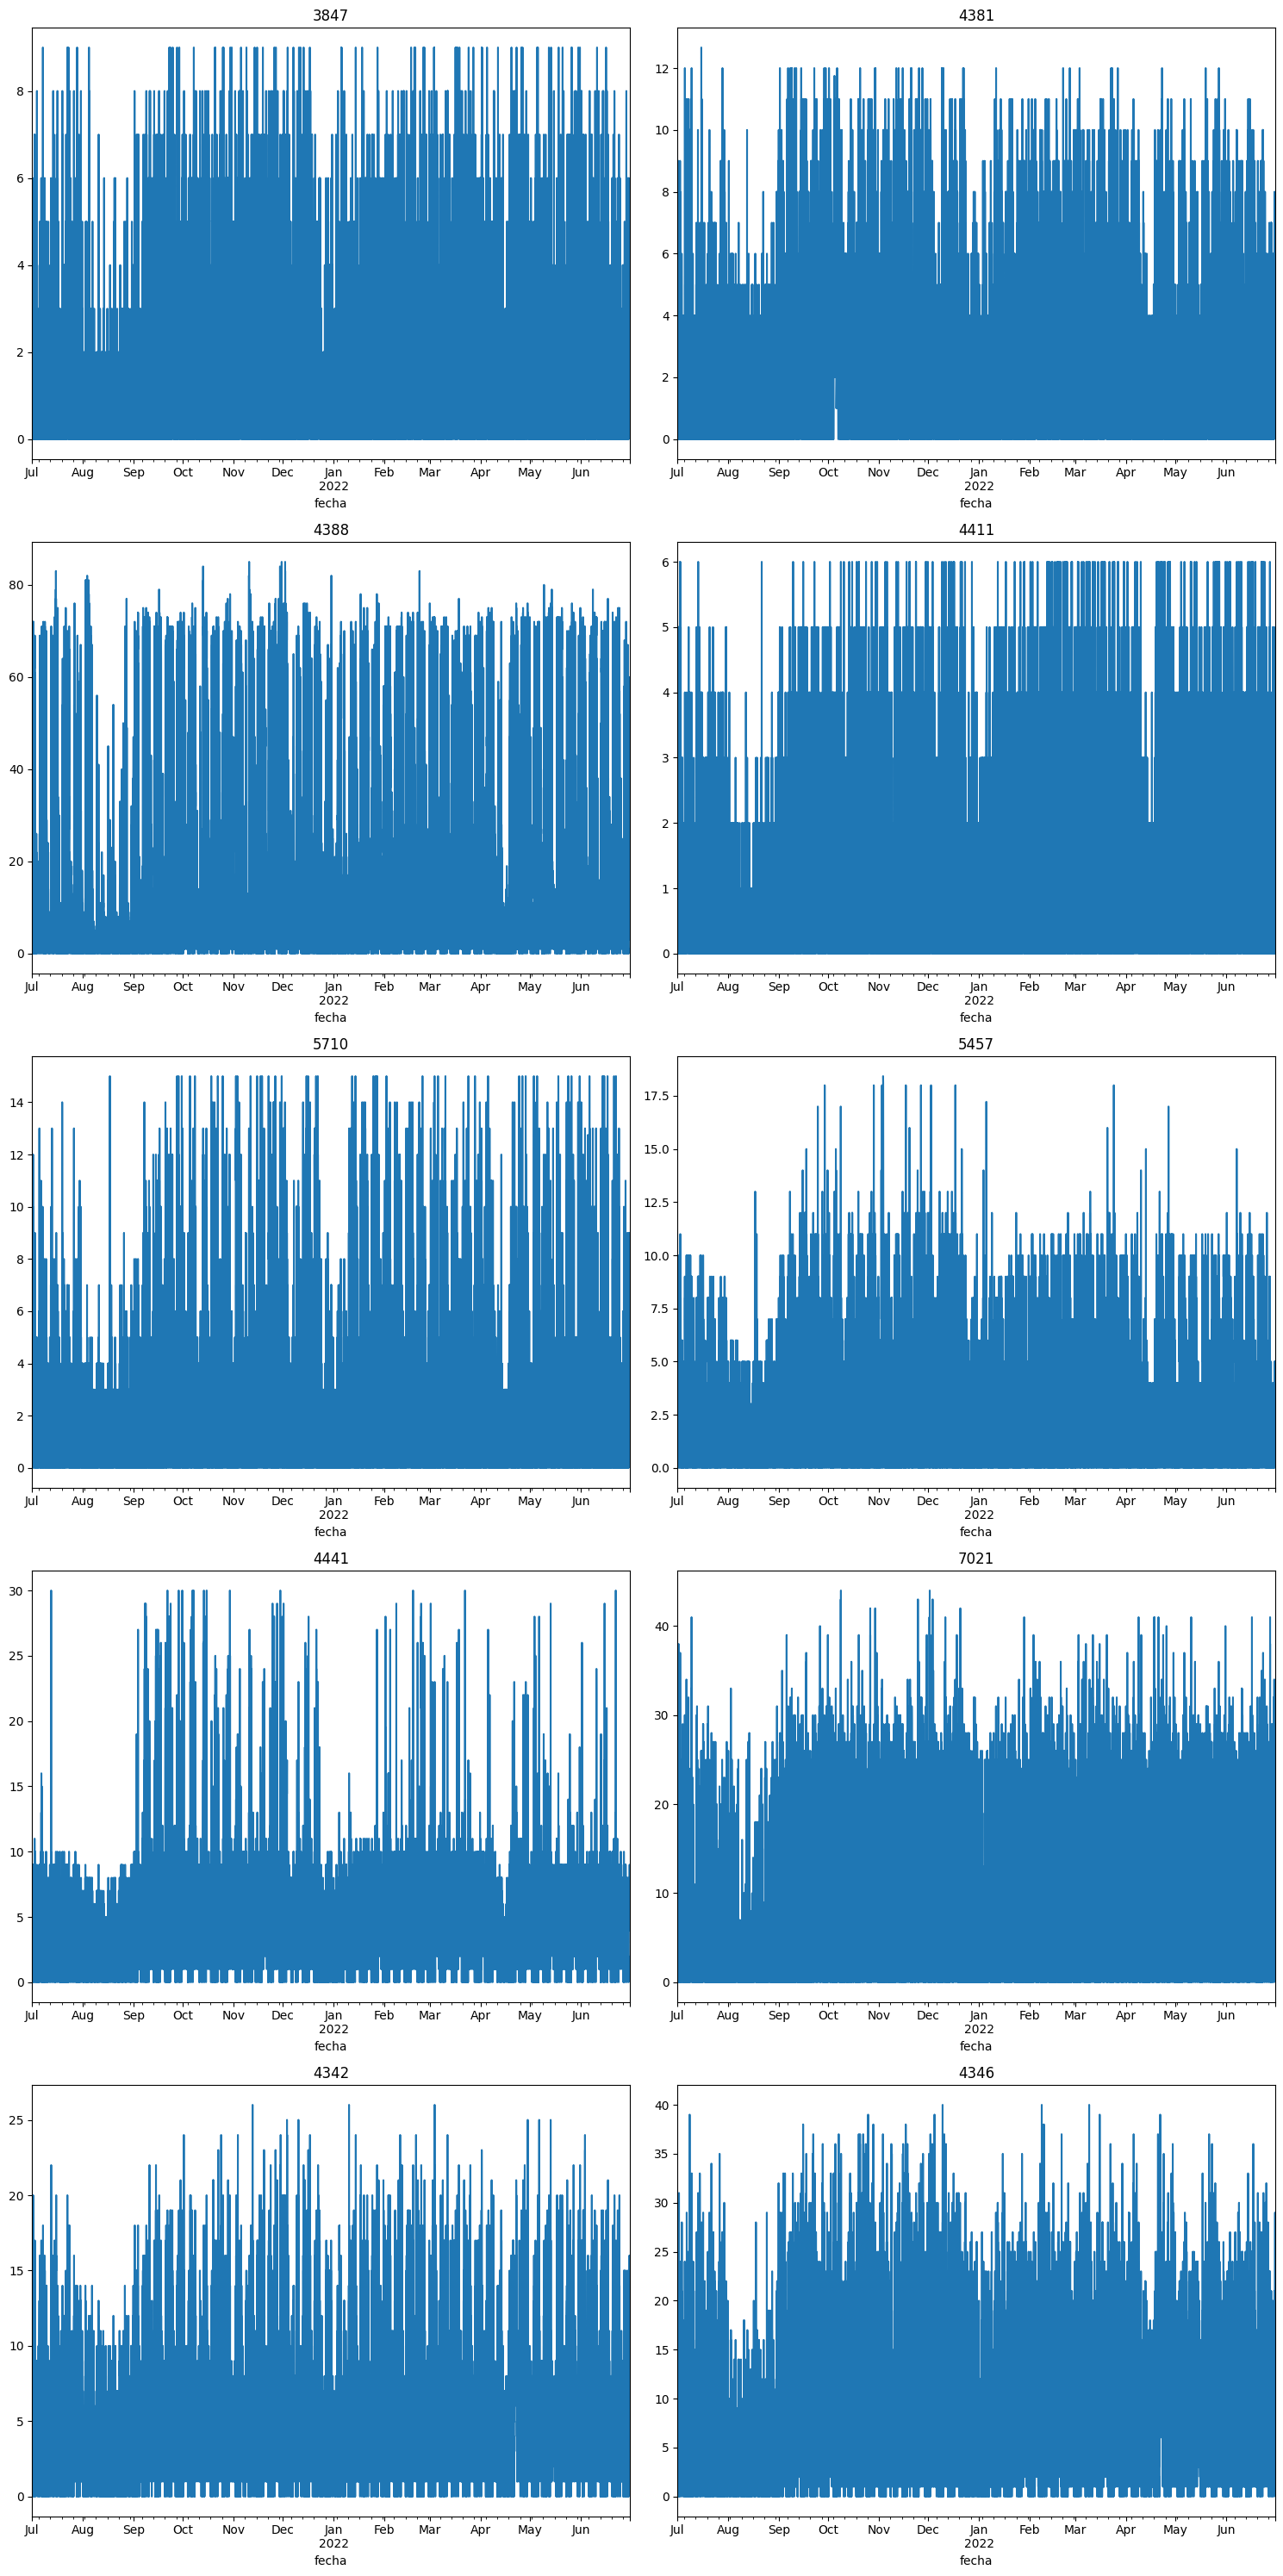

In [18]:
# Plot - occupancy

i = 0
j = 0
k = 0


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,30))
for key, df in sampled_dict.items():
    df['ocupacion'].plot(ax=axes[i,j])
    axes[i,j].title.set_text(key)
    if j == 1 and i != 4:
        j = 0
        i += 1
    elif j == 1 and i == 4:
        break
    else:
        j += 1
    k += 1

fig.tight_layout()
plt.show()

In [19]:
# Exporting the dict

with open('C:/Users/Mikel/Desktop/Archivos/Estudios/Ciencia de Datos/TFM/Tercera iteración/traffic_dict.pickle' \
          , 'wb') as handle:
    pickle.dump(clean_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)